In [1]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
from tqdm.notebook import trange

%matplotlib inline
%load_ext autoreload
%autoreload 2

# GPC tutorial

## generate toy dataset

smooth underlying function
$ f(x_1, x_2) = sin(0.15\pi u + (x_1 + x_2)) + 1, $
$ u \sim Uniform[0;1] $

class definition
$ y = round(f(x_1, x_2)) $

In [2]:
torch.manual_seed(42)
n_samples = 1000

x1 = torch.randn(n_samples, 1)
x2 = torch.randn(n_samples, 1)

u = torch.rand(1)
under_f = lambda x1, x2: 1 * torch.sin(0.15 * u * np.pi + (x1 + x2)) + 1
latent_f_val = under_f(x1, x2)
y_train_0 = torch.round(latent_f_val).long().squeeze()

x_train_0 = torch.cat((x1, x2), dim=1)

### plot the whole dataset

Text(0.5, 1.0, 'Test data points')

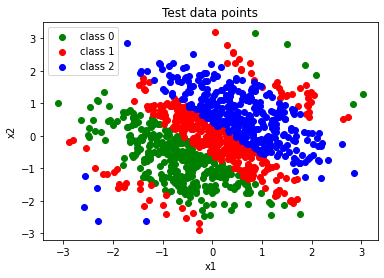

In [3]:
cdict = {1: 'red', 2: 'blue', 0: 'green'}
y_np = y_train_0.numpy()

for g in np.unique(y_np):
    ix = np.where(y_np == g)
    plt.scatter(x1.numpy()[ix], x2.numpy()[ix],
            c=cdict[g], label = f"class {g}")
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Test data points")

### split the training set into training and validation

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    x_train_0.numpy(), y_train_0.numpy(),
    test_size=0.1, stratify=y_train_0.numpy()
)

x_train = torch.tensor(X_train)
x_val   = torch.tensor(X_val)
y_train = torch.tensor(Y_train)
y_val   = torch.tensor(Y_val)

### plot split points

Text(0.5, 1.0, 'Split data points')

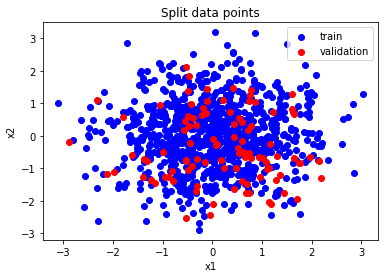

In [5]:
f, ax = plt.subplots()
ax.scatter(x_train[:,0],x_train[:,1], c="blue", label="train")
ax.scatter(x_val[:,0], x_val[:,1], c="red", label="validation")
ax.legend()
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("Split data points")

## define model

1. A **GP Model** (gpytorch.models.ExactGP) - This handles most of the inference.
2. A **Likelihood** (gpytorch.likelihoods.BernoulliLikelihood) - This is the most common likelihood used for GP classification.
3. A **Mean** - This defines the prior mean of the GP.(If you don’t know which mean to use, a gpytorch.means.ConstantMean() is a good place to start.)
4. A **Kernel** - This defines the prior covariance of the GP.(If you don’t know which kernel to use, a gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) is a good place to start).
5. A **MultivariateNormal Distribution** (gpytorch.distributions.MultivariateNormal) - This is the object used to represent multivariate normal distributions.

In [6]:
class TutorialGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood, n_classes=2):
        super(TutorialGPModel, self).__init__(x_train, y_train, likelihood)

        self.mean = gpytorch.means.ConstantMean(
            batch_shape=torch.Size((n_classes,))
        )
        self.cov  = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size((n_classes,))),
            batch_shape=torch.Size((n_classes,))
        )

    def forward(self, x):
        """
        Evaluate the mean and kernel function at the point x
        :param x:
        :return: multivariate normal
        """
        mean_x = self.mean(x)
        cov_x  = self.cov (x)

        return gpytorch.distributions.MultivariateNormal(mean_x, cov_x)

In [7]:
likelihood = gpytorch.likelihoods.DirichletClassificationLikelihood(
    y_train,
    learn_additional_noise=True
)
model = TutorialGPModel(
    x_train,
    likelihood.transformed_targets,
    likelihood,
    n_classes=likelihood.num_classes
)

## train the model

The training loop mainly consists of the following steps:

1. Setting all the parameter gradients to zero
2. Calling the model and computing the loss
3. Calling backward on the loss to fill in gradients
4. Taking a step on the optimizer

In [8]:
# put the model into training mode
model.train()
likelihood.train()

# use Adam optimizer, which includes GaussianLikelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# define negative marginal log-likelihood as the loss function
lf = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# number of training iterations
n_iter = 50

In [9]:
losses = []

# training loop
for i in trange(n_iter):
    # 1. set gradients to zero
    optimizer.zero_grad()

    # 2. call the model and compute the loss
    output = model(x_train)
    loss = -lf(output, likelihood.transformed_targets).sum()

    # 3. backprop gradients
    loss.backward()

    losses.append(loss.item())

    optimizer.step()

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Training process & loss')

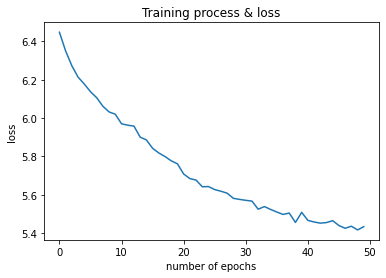

In [10]:
# plot the loss
plt.plot(losses)
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.title("Training process & loss")

## make predictions on valuation data

In [11]:
# set the model to evaluation mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_dist = model(x_val)

    pred_means = test_dist.loc